### Author: Hoang Chu

### Imports

In [53]:
%pip install -r dependencies.txt

  Using cached urllib3-2.0.5-py3-none-any.whl (123 kB)
INFO: pip is looking at multiple versions of qtpy to determine which version is compatible with other requirements. This could take a while.
  Using cached QtPy-2.3.0-py3-none-any.whl (83 kB)
INFO: pip is looking at multiple versions of qtconsole to determine which version is compatible with other requirements. This could take a while.
  Using cached qtconsole-5.4.0-py3-none-any.whl (121 kB)
INFO: pip is looking at multiple versions of pyzmq to determine which version is compatible with other requirements. This could take a while.
  Using cached pyzmq-25.0.0-cp310-cp310-macosx_10_15_universal2.whl (1.8 MB)
INFO: pip is looking at multiple versions of pyyaml to determine which version is compatible with other requirements. This could take a while.
  Using cached PyYAML-6.0-cp310-cp310-macosx_11_0_arm64.whl (173 kB)
INFO: pip is looking at multiple versions of pytz to determine which version is compatible with other requirements. Thi

In [212]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import requests
import scipy
import importlib
import helper, consts
importlib.reload(consts)
importlib.reload(helper)
import glob

### CONSTANTS

In [213]:
ROW = consts.ROW
COL = consts.COL
RAW_DATA_PATH = consts.RAW_DATA_PATH
RESPONSE_NAME = consts.RESPONSE_NAME

RESPONSE_NAME

'tonight'

### Quick Functions

In [121]:
does_sub_df_has_Nan = lambda df, col_name: df[[col_name]].isna().any(axis=COL)

### Read data

In [157]:
testday = '20170103'

trainRange = helper.get_train_from_testday(testday)
training_range = f"{trainRange[0]}-{trainRange[1]}"
files = helper.get_file_names(trainRange[0],trainRange[1]) # get filenames from before 6/1/2015

In [152]:
# local read

# take in testing day - split into year and month 

dfs = [pd.read_csv(consts.RAW_DATA_PATH + f"{f}") for f in files]
main_df = pd.concat(dfs)

testfile = f"data.{testday}_1200.csv"
test_df = pd.read_csv(consts.RAW_DATA_PATH + testfile)

x_cols = ["rrirpnxm_nt_0", "rrirpnxm_lst15_0","rrirpnxm_lsthrx15_0", "rrirpnxm_toxhr_0"]
saved_cols = x_cols + [RESPONSE_NAME]

# training_df and testing_df are the result of selecting necessary columns from 
# main_df (concatenated training files) and test_df
training_df = main_df[saved_cols]
testing_df = test_df[saved_cols]



### Feature Selection

##### Preliminary check

In [135]:
main_df.shape

(821259, 252)

In [164]:
test_df.shape

(3022, 252)

In [166]:
print(f"{training_range}:")
main_df.info()
print(f"Columns with NaN: {main_df[main_df.isna().any(axis=COL)]}")

print()

print(f"{testday}:")
test_df.info()
print(f"Columns with NaN: {test_df[test_df.isna().any(axis=COL)]}")

20151101-20161131:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 821259 entries, 0 to 2965
Columns: 252 entries, eqid to tr_toxhr_0
dtypes: float64(251), int64(1)
memory usage: 1.5 GB
Columns with NaN: Empty DataFrame
Columns: [eqid, wt, today, tonight, tmwam, dn3sttmwmd, dn1, dn4x1, cftorrrelstd_open_0, liqlog_open_0, llirpnxm_am_1, llirpnxm_dy_12to16, llirpnxm_dy_17to21, llirpnxm_dy_1to3, llirpnxm_dy_4to6, llirpnxm_dy_7to11, llirpnxm_lst15_0, llirpnxm_lsthrx15_0, llirpnxm_md_1, llirpnxm_nt_0, llirpnxm_nt_1, llirpnxm_nt_12to16, llirpnxm_nt_17to21, llirpnxm_nt_1to3, llirpnxm_nt_4to6, llirpnxm_nt_7to11, llirpnxm_pm_1, llirpnxm_toxhr_0, mocrelvol_open_1, mocrelvol_open_13to17, mocrelvol_open_18to22, mocrelvol_open_2to4, mocrelvol_open_5to7, mocrelvol_open_8to12, momr10d_open_0, momr50dx10d_open_0, moorelvol_open_0, moorelvol_open_12to16, moorelvol_open_17to21, moorelvol_open_1to3, moorelvol_open_4to6, moorelvol_open_7to11, nnetticksrelmultstdev_am_1, nnetticksrelmultstdev_dy_12to16, 

In [167]:
print(f"{training_range} - unique eqid count: {main_df.eqid.nunique()}")
print(f"{testday} - unique eqid count: {test_df.eqid.nunique()}")

20151101-20161131 - unique eqid count: 3500
20170103 - unique eqid count: 3022


In [168]:
main_df.drop('eqid', axis=COL, inplace=True)
test_df.drop('eqid', axis=COL, inplace=True)

In [171]:
print(f"training set {training_range}:")
main_df.describe().loc[['min', 'max']]

training set 20151101-20161131:


,wt,today,tonight,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,llirpnxm_am_1,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
min,0.000014,-0.098567,-0.208517,-0.154224,-0.524020,-0.268989,-0.523127,-1.898721,-3.537791,-0.053295,...,-0.231109,-0.262378,-0.262378,-0.268973,-0.268973,-0.262378,-0.262378,-0.268973,-0.240125,-0.233899
max,0.001502,0.143506,0.155209,0.106887,0.457212,0.253791,0.445909,2.754416,1.553464,0.059075,...,0.352210,0.371709,0.371709,0.645513,0.645513,0.371709,0.516280,0.645513,0.335358,0.343746


In [170]:
print(f"{testday}:")
test_df.describe().loc[['min', 'max']]

20170103:


,wt,today,tonight,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,llirpnxm_am_1,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
min,0.000015,-0.050281,-0.040389,-0.051078,-0.196519,-0.144193,-0.209676,-1.687123,-3.340231,-0.009126,...,-0.030750,-0.222302,-0.111361,-0.214568,-0.153808,-0.111361,-0.133286,-0.242981,-0.038871,-0.039814
max,0.001448,0.048443,0.065338,0.059542,0.208261,0.098327,0.205890,2.266250,1.502859,0.014586,...,0.038394,0.073906,0.020176,0.327330,0.240872,0.066102,0.104354,0.249099,0.045030,0.058639


In [172]:
RESPONSE_NAME

'tonight'

##### Get the responses columns

In [175]:
training_responses = main_df[RESPONSE_NAME]
testing_responses = test_df[RESPONSE_NAME]

##### Training Data

In [176]:
main_df.drop(RESPONSE_NAME, axis=COL, inplace=True)

In [177]:
main_df.corr().isna().sum()

wt             7
today          7
tmwam          7
dn3sttmwmd     7
dn1            7
              ..
tr_nt_1to3     7
tr_nt_4to6     7
tr_nt_7to11    7
tr_pm_1        7
tr_toxhr_0     7
Length: 250, dtype: int64

Some column pairs have NaN correlations, meaning either or both columns have constant values in all rows.

In [178]:
# Get columns where all rows have the same value
constVal_columns = main_df.columns[main_df.apply(lambda x: x.nunique() == 1)]
constVal_columns

Index(['rvdelta_nt_0', 'rvdelta_nt_1', 'rvdelta_nt_12to16',
       'rvdelta_nt_17to21', 'rvdelta_nt_1to3', 'rvdelta_nt_4to6',
       'rvdelta_nt_7to11'],
      dtype='object')

In [179]:
TOBE_REMOVED_20191202_1200_COLUMNS = list(constVal_columns)

##### Testing Data

In [180]:
test_df.drop(RESPONSE_NAME, axis=COL, inplace=True)

In [181]:
test_df.corr().isna().sum()

wt             10
today          10
tmwam          10
dn3sttmwmd     10
dn1            10
               ..
tr_nt_1to3     10
tr_nt_4to6     10
tr_nt_7to11    10
tr_pm_1        10
tr_toxhr_0     10
Length: 250, dtype: int64

In [182]:
# Get columns where all rows have the same value
constVal_columns = test_df.columns[test_df.apply(lambda x: x.nunique() == 1)]
constVal_columns

Index(['qe_nt0_open_0', 'qe_prv1_open_0', 'qe_prv2_open_0', 'rvdelta_nt_0',
       'rvdelta_nt_1', 'rvdelta_nt_12to16', 'rvdelta_nt_17to21',
       'rvdelta_nt_1to3', 'rvdelta_nt_4to6', 'rvdelta_nt_7to11'],
      dtype='object')

In [183]:
TOBE_REMOVED_20191203_1200_COLUMNS = list(constVal_columns)

##### Get training_predictors_df and testing_predictors_df

In [184]:
TOBE_REMOVED_20191202_1200_COLUMNS_set = set(TOBE_REMOVED_20191202_1200_COLUMNS)
TOBE_REMOVED_20191203_1200_COLUMNS_set = set(TOBE_REMOVED_20191203_1200_COLUMNS)

In [185]:
# Appear in TOBE_REMOVED_20191202_1200_COLUMNS_set but not in TOBE_REMOVED_20191203_1200_COLUMNS_set
print(TOBE_REMOVED_20191202_1200_COLUMNS_set - TOBE_REMOVED_20191203_1200_COLUMNS_set)

set()


In [186]:
# Appear in TOBE_REMOVED_20191203_1200_COLUMNS_set but not in TOBE_REMOVED_20191202_1200_COLUMNS_set
print(TOBE_REMOVED_20191203_1200_COLUMNS_set - TOBE_REMOVED_20191202_1200_COLUMNS_set)

{'qe_prv2_open_0', 'qe_nt0_open_0', 'qe_prv1_open_0'}


In [187]:
remove_20191202_stay_20191203_columns = list(TOBE_REMOVED_20191202_1200_COLUMNS_set - TOBE_REMOVED_20191203_1200_COLUMNS_set)
remove_20191202_stay_20191203_columns

[]

In [188]:
# data_20150602_1200_df[remove_20191202_stay_20191203_columns].describe()

In [189]:
TOBE_REMOVED_COLUMNS = TOBE_REMOVED_20191202_1200_COLUMNS

Since there are variances among those columns, I don't think removing them now benefits the model.

In [195]:
# this set of dfs removes the columns selected from the above process
train_working_df = main_df.drop(TOBE_REMOVED_COLUMNS, axis=COL)
test_working_df = test_df.drop(TOBE_REMOVED_COLUMNS, axis=COL)

Rosy: we will not remove the columns right now from above, instead, we will just select the predictor columns we want to use

In [192]:
# this set of dfs removes the columns we manually selected 
# TODO: add the interacting terms?
training_working_df = main_df[['rrirpnxm_nt_0','rrirpnxm_lst15_0','rrirpnxm_toxhr_0','rrirpnxm_lsthrx15_0']].copy()
testing_working_df = test_df[['rrirpnxm_nt_0','rrirpnxm_lst15_0','rrirpnxm_toxhr_0','rrirpnxm_lsthrx15_0']].copy()


In [193]:
print(f"1% negative correlations ranking: {sorted(training_working_df.corr().quantile(0.1), reverse=True)}")
print(f"99% negative correlations ranking: {sorted(training_working_df.corr().quantile(0.9), reverse=True)}")
training_working_df.corr().describe()

1% negative correlations ranking: [-0.02421945627331741, -0.03354083336504846, -0.045436966956658026, -0.053742568271335944]
99% negative correlations ranking: [0.7016684676479661, 0.7016684676479661, 0.699722738496134, 0.6987069627190808]


,rrirpnxm_nt_0,rrirpnxm_lst15_0,rrirpnxm_toxhr_0,rrirpnxm_lsthrx15_0
count,4.000000,4.000000,4.000000,4.000000
mean,0.232926,0.242609,0.227626,0.232373
std,0.512178,0.505228,0.515680,0.511932
min,-0.063063,-0.034203,-0.063063,-0.034203
25%,-0.018998,-0.009244,-0.039762,-0.032547
50%,-0.002617,0.002319,-0.013217,-0.018153
75%,0.249307,0.254171,0.254171,0.246767
max,1.000000,1.000000,1.000000,1.000000


In [196]:
# Box to do figure out which columns to use
training_predictors_df = train_working_df.copy()
testing_predictors_df = test_working_df.copy()

In [197]:
sorted(training_predictors_df.quantile(0.25) / training_predictors_df.quantile(0.01), reverse=True)[:2]

[3.6111111111111107, 0.6579554777470543]

In [198]:
sorted(training_predictors_df.quantile(0.99) / training_predictors_df.quantile(0.75), reverse=True)[:2]

[inf, inf]

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 1.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00,
        0.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        3.00000e+00, 9.00000e+00, 6.00000e+00, 1.20000e+01, 1.00000e+01,
        1.70000e+01, 2.00000e+01, 2.30000e+01, 3.00000e+01, 5.20000e+01,
        4.60000e+01, 8.00000e+01, 7.60000e+01, 8.40000e+01, 1.40000e+02,
        2.00000e+02, 2.77000e+02, 3.83000e+02, 5.24000e+02, 7.33000e+02,
        1.02200e+03, 1.47700e+03, 2.08800e+03, 3.17100e+03, 4.58900e+03,
        7.04400e+03, 1.08660e+04, 1.69140e+04, 2.77770e+04, 4.80630e+04,
        8.55160e+04, 1.40346e+05, 1.71534e+05, 1.23328e+05, 6.98570e+04,
        3.89500e+04, 2.24370e+04, 1.38660e+04, 9.08800e+03, 6.01700e+03,
        4.08100e+03, 2.87300e+03, 2.01400e+03, 1.43

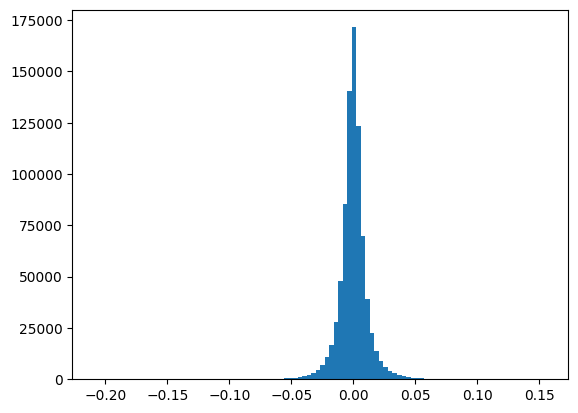

In [199]:
plt.hist(training_responses, bins=100)

#### Detect influential points

I will use Mahalanobis distance, which computes distances from the data's centre and create an oval boundary.

In [200]:
mean_vector = np.mean(training_predictors_df, axis=0)
cov_matrix = np.cov(training_predictors_df, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

In [201]:
mahalanobis_distances = []
for index, row in training_predictors_df.iterrows():
    mahalanobis_distance = scipy.spatial.distance.mahalanobis(row, mean_vector, inv_cov_matrix)
    mahalanobis_distances.append(mahalanobis_distance)

/opt/homebrew/lib/python3.10/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


In [202]:
training_predictors_df['mahalanobis_dist'] = mahalanobis_distances
training_predictors_df.head()

,wt,today,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,llirpnxm_am_1,llirpnxm_dy_12to16,...,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0,mahalanobis_dist
0,0.001426,-0.003854,0.009575,-0.035341,0.017768,-0.025615,-0.031780,0.952881,-0.002913,-0.020135,...,0.000000,0.000000,-0.008639,0.000000,0.000000,0.000000,0.000000,0.0,0.0,14.668976
1,0.001426,-0.002452,0.005502,0.005558,0.005536,0.008619,-0.571585,1.506842,-0.000316,0.002813,...,0.000000,0.000000,0.000000,-0.000889,0.000000,-0.002749,0.000000,0.0,0.0,13.261432
2,0.000103,-0.009077,-0.001128,0.005127,-0.008287,0.015368,-0.659948,-1.757289,-0.000627,-0.020681,...,0.000000,0.000000,0.000000,0.000000,0.110287,0.000000,-0.019189,0.0,0.0,18.273537
3,0.000090,0.000551,0.001066,-0.012716,0.006461,-0.020088,0.466829,-1.882431,0.002429,-0.000644,...,0.000000,0.000000,-0.013316,0.000000,0.000000,0.000000,0.000000,0.0,0.0,12.664531
4,0.000100,0.010167,-0.000366,0.044176,0.001127,0.052270,-1.001732,-1.783126,-0.000593,0.002370,...,-0.005214,0.023126,0.000000,0.000000,0.023126,-0.029055,0.000000,0.0,0.0,17.556826


In [203]:
#TODO: Need discussion
mahal_threshold = 3 # Typical 'mahal_threshold' is 3
outlier_significance_val = .001

In [204]:
training_predictors_df['mahal_p_value'] = 1 - scipy.stats.chi2.cdf(training_predictors_df['mahalanobis_dist'], mahal_threshold)

In [205]:
outlier_condition = (training_predictors_df['mahal_p_value'] < outlier_significance_val)

In [206]:
nonOutlier_indices = training_predictors_df[~outlier_condition].index

In [207]:
temp_col = 'response'
training_predictors_df[temp_col] = training_responses

training_predictors_df = training_predictors_df[~outlier_condition]

training_responses = training_predictors_df[temp_col]
training_predictors_df.drop(temp_col, axis=COL, inplace=True)

In [208]:
training_predictors_df.drop(['mahalanobis_dist', 'mahal_p_value'], axis = COL, inplace=True)
training_predictors_df.reset_index(drop=True)
training_predictors_df.head()

,wt,today,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,llirpnxm_am_1,llirpnxm_dy_12to16,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
0,0.001426,-0.003854,0.009575,-0.035341,0.017768,-0.025615,-0.031780,0.952881,-0.002913,-0.020135,...,0.0,0.0,0.0,-0.008639,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0.001426,-0.002452,0.005502,0.005558,0.005536,0.008619,-0.571585,1.506842,-0.000316,0.002813,...,0.0,0.0,0.0,0.000000,-0.000889,0.000000,-0.002749,0.000000,0.0,0.0
3,0.000090,0.000551,0.001066,-0.012716,0.006461,-0.020088,0.466829,-1.882431,0.002429,-0.000644,...,0.0,0.0,0.0,-0.013316,0.000000,0.000000,0.000000,0.000000,0.0,0.0
5,0.000154,-0.006419,-0.002538,-0.003684,-0.008578,-0.004521,-0.930212,-1.363291,0.001795,-0.018409,...,0.0,0.0,0.0,0.000000,0.000000,-0.004651,0.000000,0.000000,0.0,0.0
7,0.001426,0.003193,-0.001535,0.005875,0.002755,0.003176,1.283096,1.022995,-0.000543,0.000075,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.004714,0.0,0.0


#### Merge features and responses

In [209]:
train_df = pd.concat([training_predictors_df, pd.DataFrame({consts.RESPONSE_NAME: training_responses})], 
                     axis=COL)
test_df = pd.concat([testing_predictors_df, pd.DataFrame({consts.RESPONSE_NAME: testing_responses})], 
                    axis=COL)

### Output

In [210]:
out_train_filename = 'training_data.csv'
out_test_filename = 'testing_data.csv'

In [211]:
train_df.to_csv(consts.CLEANED_DATA_PATH + out_train_filename, index=False)
test_df.to_csv(consts.CLEANED_DATA_PATH + out_test_filename, index=False)

In [ ]:
%pip freeze > dependencies.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
dfs = [pd.read_csv(consts.RAW_DATA_PATH + f"/{f}") for f in files]

In [ ]:
dfs[0].head(5)

,eqid,wt,today,tonight,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
0,2,0.001362,-0.000000,-0.000073,-0.000044,0.043301,-0.000197,0.044070,-0.039664,0.937606,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,24,0.001362,0.005238,-0.004306,-0.002262,0.013892,-0.004823,0.024938,-0.157931,1.625474,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,31,0.000136,0.011490,0.004177,0.001118,0.018716,0.020808,0.006395,-0.669988,-1.475189,...,-0.004859,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,39,0.000109,-0.000000,-0.000073,-0.000044,0.003619,-0.000197,0.004096,1.558111,-1.694274,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.007313,0.0,0.0
4,41,0.000167,0.011016,-0.007763,0.002544,-0.054440,0.007580,-0.046610,-0.121591,-1.274620,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
dfs[-1].tail(5)

,eqid,wt,today,tonight,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
3141,48962,0.000024,-0.031472,-0.009722,0.016301,0.123158,-0.023162,0.121168,-1.611105,-3.192309,...,0.0,0.0,0.0,-0.043044,0.004708,0.0,0.0,0.000000,0.0,0.0
3142,48964,0.000029,-0.000485,-0.010842,0.015855,-0.013404,0.003760,-0.021294,-1.396151,-3.012063,...,0.0,0.0,0.0,0.007081,0.000000,0.0,0.0,-0.015039,0.0,0.0
3143,48966,0.000026,0.016961,-0.000778,0.008409,-0.032120,0.057929,-0.077203,-1.611105,-3.105070,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
3144,48968,0.000126,-0.013461,0.006066,-0.003501,-0.101850,-0.018021,-0.085610,-1.521752,-1.545402,...,0.0,0.0,0.0,0.000000,0.008433,0.0,0.0,0.000000,0.0,0.0
3145,48984,0.000029,0.000964,0.001281,0.003754,0.003692,0.005564,0.007869,-1.281911,-2.994303,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


In [ ]:
main_df = pd.concat(dfs)
main_df

,eqid,wt,today,tonight,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
0,2,0.001362,-0.000000,-0.000073,-0.000044,0.043301,-0.000197,0.044070,-0.039664,0.937606,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,24,0.001362,0.005238,-0.004306,-0.002262,0.013892,-0.004823,0.024938,-0.157931,1.625474,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,31,0.000136,0.011490,0.004177,0.001118,0.018716,0.020808,0.006395,-0.669988,-1.475189,...,-0.004859,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
3,39,0.000109,-0.000000,-0.000073,-0.000044,0.003619,-0.000197,0.004096,1.558111,-1.694274,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.007313,0.0,0.0
4,41,0.000167,0.011016,-0.007763,0.002544,-0.054440,0.007580,-0.046610,-0.121591,-1.274620,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,48962,0.000024,-0.031472,-0.009722,0.016301,0.123158,-0.023162,0.121168,-1.611105,-3.192309,...,0.000000,0.0,0.0,-0.043044,0.004708,0.0,0.0,0.000000,0.0,0.0
3142,48964,0.000029,-0.000485,-0.010842,0.015855,-0.013404,0.003760,-0.021294,-1.396151,-3.012063,...,0.000000,0.0,0.0,0.007081,0.000000,0.0,0.0,-0.015039,0.0,0.0
3143,48966,0.000026,0.016961,-0.000778,0.008409,-0.032120,0.057929,-0.077203,-1.611105,-3.105070,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
3144,48968,0.000126,-0.013461,0.006066,-0.003501,-0.101850,-0.018021,-0.085610,-1.521752,-1.545402,...,0.000000,0.0,0.0,0.000000,0.008433,0.0,0.0,0.000000,0.0,0.0
